## BC Raw Log Exports

Data taken from [Forest - BC Govt](https://www2.gov.bc.ca/gov/content/data/statistics/business-industry-trade/industry/forestry)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [38]:
raw_data = pd.read_csv("raw_data/BCLogExports_MinFor_180112.csv",header=1,thousands=",").dropna(how='any')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735 entries, 0 to 7734
Data columns (total 6 columns):
Year                   7735 non-null object
Month                  7735 non-null object
Commodity              7735 non-null object
Destination Country    7735 non-null object
Value - Cdn $          7735 non-null float64
Quantity - m3          7735 non-null float64
dtypes: float64(2), object(4)
memory usage: 423.0+ KB


In [39]:
raw_data.columns = ["Year","Month","Commodity",'Destination','Value','Quantity']

In [48]:
dfMonths = pd.DataFrame({'Month':['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],'MonthIndex':range(12)})
data = pd.merge(raw_data,dfMonths,on="Month")
data['Year'] = data['Year'].apply(int)

In [54]:
aggregated = data.groupby(['Year','Destination'])['Value','Quantity'].sum()
totals = aggregated.reset_index().groupby(['Year']).sum()

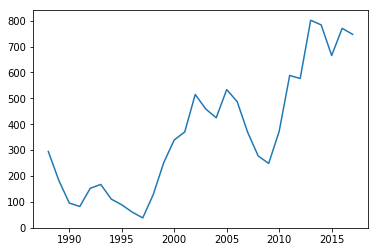

In [59]:
plt.plot(totals['Value']/1000000)

In [66]:
annual_pivot = aggregated.reset_index().pivot(index="Year",columns="Destination",values="Value").fillna(0)
annual_pivot.columns

Index(['Albania', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Belgium', 'Bermuda', 'Czech Republic', 'Denmark',
       'Finland', 'France', 'French Polynesia', 'Germany', 'Greece',
       'Guatemala', 'Hong Kong', 'Iceland', 'India', 'Indonesia', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Laos',
       'Latvia', 'Lebanon', 'Mainland China', 'Malaysia', 'Mexico',
       'Netherlands', 'New Zealand', 'North Korea', 'Pakistan', 'Peru',
       'Philippines', 'Russia', 'Saudi Arabia', 'Singapore', 'South Africa',
       'South Korea', 'Spain', 'St Pierre-Miquelin', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Vietnam'],
      dtype='object', name='Destination')

,Value,Quantity
Year,,
1988,294932334.0,3183121.0
1989,183408318.0,1968056.0
1990,95646194.0,797274.0
1991,82323540.0,766495.0
1992,152737916.0,1165655.0
1993,167591368.0,1027330.0
1994,110803345.0,719392.0
1995,88832654.0,620699.0
1996,60501972.0,377537.0
